In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
sys.path.append('../../')
from vis.plotting.utils import resize_by_tradeoff, color_by_dist, color_by_cv, enhance_color

def load_props(path):
    r"""
    Load CV, Mu, Ik and S from path.
    """
    CV = None
    cvpathf = os.path.join(path, "datacv.csv")
    if os.path.exists(cvpathf):
        CV = np.loadtxt(cvpathf)

    # load the Mu values
    Mu = None
    mupathf = os.path.join(path, "mu.csv")
    if os.path.exists(mupathf):
        Mu = np.loadtxt(mupathf)

    # load the knee indices
    Ik = None
    kpathf = os.path.join(path, "muid.csv")
    if os.path.exists(kpathf):
        Ik = np.loadtxt(kpathf, dtype = int)
        
    return CV, Mu, Ik

def decide_size_color(CV, Mu, Ik):
    r"""
    Decide point-size and color from `CV`, `Mu` and `Ik`
    """
    # decide point-size
    S = 1
    if Mu is not None and Ik is not None:
        S = resize_by_tradeoff(Mu, k=Ik)

    # decide colors
    # C = default_color(F.shape[0], alpha=0.5)
    M = np.mean(F, axis=0)
    C, D = color_by_dist(F, M)
    
    # if CV is available, use CV to color
    if CV is not None:
        C = color_by_cv(CV)

    # enhance knee points
    if Ik is not None:
        C = enhance_color(C, Ik)
    return S, C, D

pfs = {'dtlz2': ['3d', '4d', '8d'], \
       'dtlz2-nbi': ['3d', '4d', '5d', '8d'], \
       'debmdk': ['3d', '4d', '8d'], \
       'debmdk-nbi': ['3d', '4d', '8d'], \
       'debmdk-all': ['3d', '4d', '8d'], \
       'debmdk-all-nbi': ['3d', '4d', '8d'], \
       'dtlz8': ['3d', '4d', '6d', '8d'], \
       'dtlz8-nbi': ['3d', '4d', '6d', '8d'], \
       'c2dtlz2': ['3d', '4d', '5d', '8d'], \
       'c2dtlz2-nbi': ['3d', '4d', '5d', '8d'], \
       'cdebmdk': ['3d', '4d', '8d'], \
       'cdebmdk-nbi': ['3d', '4d', '8d'], \
       'c0dtlz2': ['3d', '4d', '8d'], \
       'c0dtlz2-nbi': ['3d', '4d', '8d'], \
       'crash-nbi': ['3d'], 'crash-c1-nbi': ['3d'], 'crash-c2-nbi': ['3d'], \
       'gaa': ['10d'], \
       'gaa-nbi': ['10d']}

constrained_pfs = ['dtlz8', 'dtlz8-nbi', 'c2dtlz2', 'c2dtlz2-nbi', 'cdebmdk', 'cdebmdk-nbi', \
                   'c0dtlz2', 'c0dtlz2-nbi', 'gaa', 'gaa-nbi']

./data/debmdk-nbi/3d/dataf.csv (1143, 3) ['.', 'data', 'debmdk-nbi', '3d'] debmdk-nbi
[   0   25   26   27   28   53  791 1138 1142]


<IPython.core.display.Javascript object>


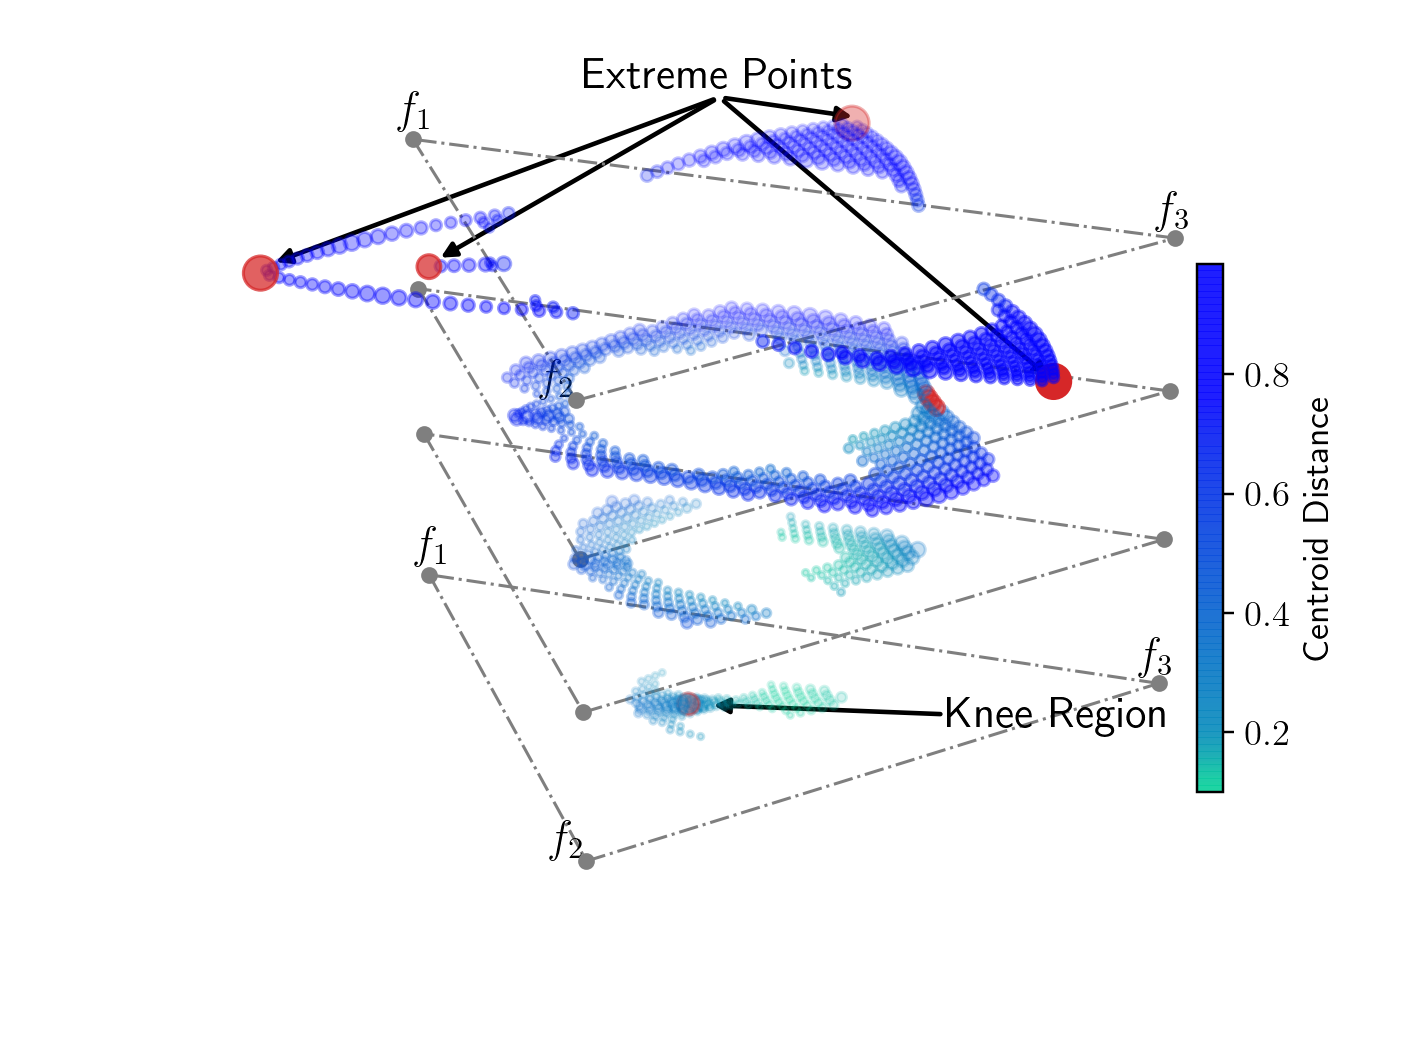

Plotting palette-star-viz.
Loading depth contours from ./data/debmdk-nbi/3d/depth-cont-cvhull.csv.


In [22]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star
from vis.plotting.utils import Arrow3D

for pf in ['debmdk-nbi']:
    for dim in ['3d']:
        fullpathf = "./data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
        if os.path.exists(fullpathf):
            path, filenamef = os.path.split(fullpathf)
            dirs = path.split('/')
            frontname = dirs[-2]

            # load the front
            F = np.loadtxt(fullpathf, delimiter=',')
            print(fullpathf, F.shape, dirs, frontname)
            
            # decide color and sizes
            CV, Mu, Ik = load_props(path)
            S,C,D = decide_size_color(CV, Mu, Ik)
            print(Ik)
            
            # make indices for knee and non-knee points
            I = np.zeros(F.shape[0]).astype(bool)
            I[Ik] = True
            Ip, Ik = ~I, I
            
            # fix point labels
            L = np.array(["" for _ in range(F.shape[0])]).astype(object)
            L[Ip] = "All Other Points"
            L[Ik] = "Knee Points"
            
            # decide what label and gradient to use for the colorbar
            if pf in constrained_pfs:
                cbl = "Normalized Cumulative CV"
                cbg = CV
            else:
                cbl = "Centroid Distance"
                cbg = D
            
            figpath = os.path.join(path, "knee-3d-norm-palette-invsc-knee-marked.pdf")
            depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
            with plt.rc_context({"text.usetex": True, "font.size": 12}):
                # plot
                ax = Axes3D(plt.figure())
                # a more elaborate example
                _,P = paletteviz.plot(F, ax=ax, depth_contours=depth_contour_path, mode='star', \
                                n_partitions=4, s=S, c=C, labels=None, euler=(140,30), \
                                colorbar=(C[Ip], cbg[Ip], cbl, -0.25), verbose=True, \
                                draw_anchors={'labels': [0,3], \
                                              'polygons': [0,1,2,3], \
                                              'circles': []})
                # draw arrows and texts
                # knee point
                ax.text(-0.35, -0.35, z=0.21, s=r'Knee Region', ha='left', va='bottom', fontsize='large')
                a = Arrow3D([-0.35, P[791,0]-0.03], [-0.35, P[791,1]-0.03], [0.25, P[791,2]], \
                                mutation_scale = 10, lw = 1.5, arrowstyle = "-|>", color = 'black')
                ax.add_artist(a)

                # Extreme points
                ax.text(0.0, 0.0, z=1.25, s=r'Extreme Points', ha='center', va='bottom', fontsize='large')
                a = Arrow3D([0.0, P[1138,0]-0.01], [0.0, P[1138,1]-0.01], [1.25, P[1138,2]+0.01], \
                                mutation_scale = 10, lw = 1.5, arrowstyle = "-|>", color = 'black')
                ax.add_artist(a)
                a = Arrow3D([0.0, P[1142,0]-0.015], [0.0, P[1142,1]-0.015], [1.25, P[1142,2]+0.015], \
                            mutation_scale = 10, lw = 1.5, arrowstyle = "-|>", color = 'black')
                ax.add_artist(a)
                a = Arrow3D([0.0, P[0,0]], [0.0, P[0,1]], [1.25, P[0,2]], \
                            mutation_scale = 10, lw = 1.5, arrowstyle = "-|>", color = 'black')
                ax.add_artist(a)
                a = Arrow3D([0.0, P[53,0]-0.01], [0.0, P[53,1]-0.01], [1.25, P[53,2]+0.01], \
                            mutation_scale = 10, lw = 1.5, arrowstyle = "-|>", color = 'black')
                ax.add_artist(a)

                # try to remove white space as much as possible
                plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
                plt.margins(0,0,0)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.gca().yaxis.set_major_locator(plt.NullLocator())
                plt.gca().zaxis.set_major_locator(plt.NullLocator())

                # save the fig
                plt.savefig(figpath, bbox_inches='tight', dpi=150, pad_inches=0)

                # show
                plt.show()

./data/debmdk-nbi/8d/dataf.csv (5083, 8) ['.', 'data', 'debmdk-nbi', '8d'] debmdk-nbi
[   0    7   35  119  245  280  329  686  706  712  714  715  791 1715
 3431 4316 4337 4338 4343 4344 4345 5047 5075 5076 5080 5081 5082]


<IPython.core.display.Javascript object>


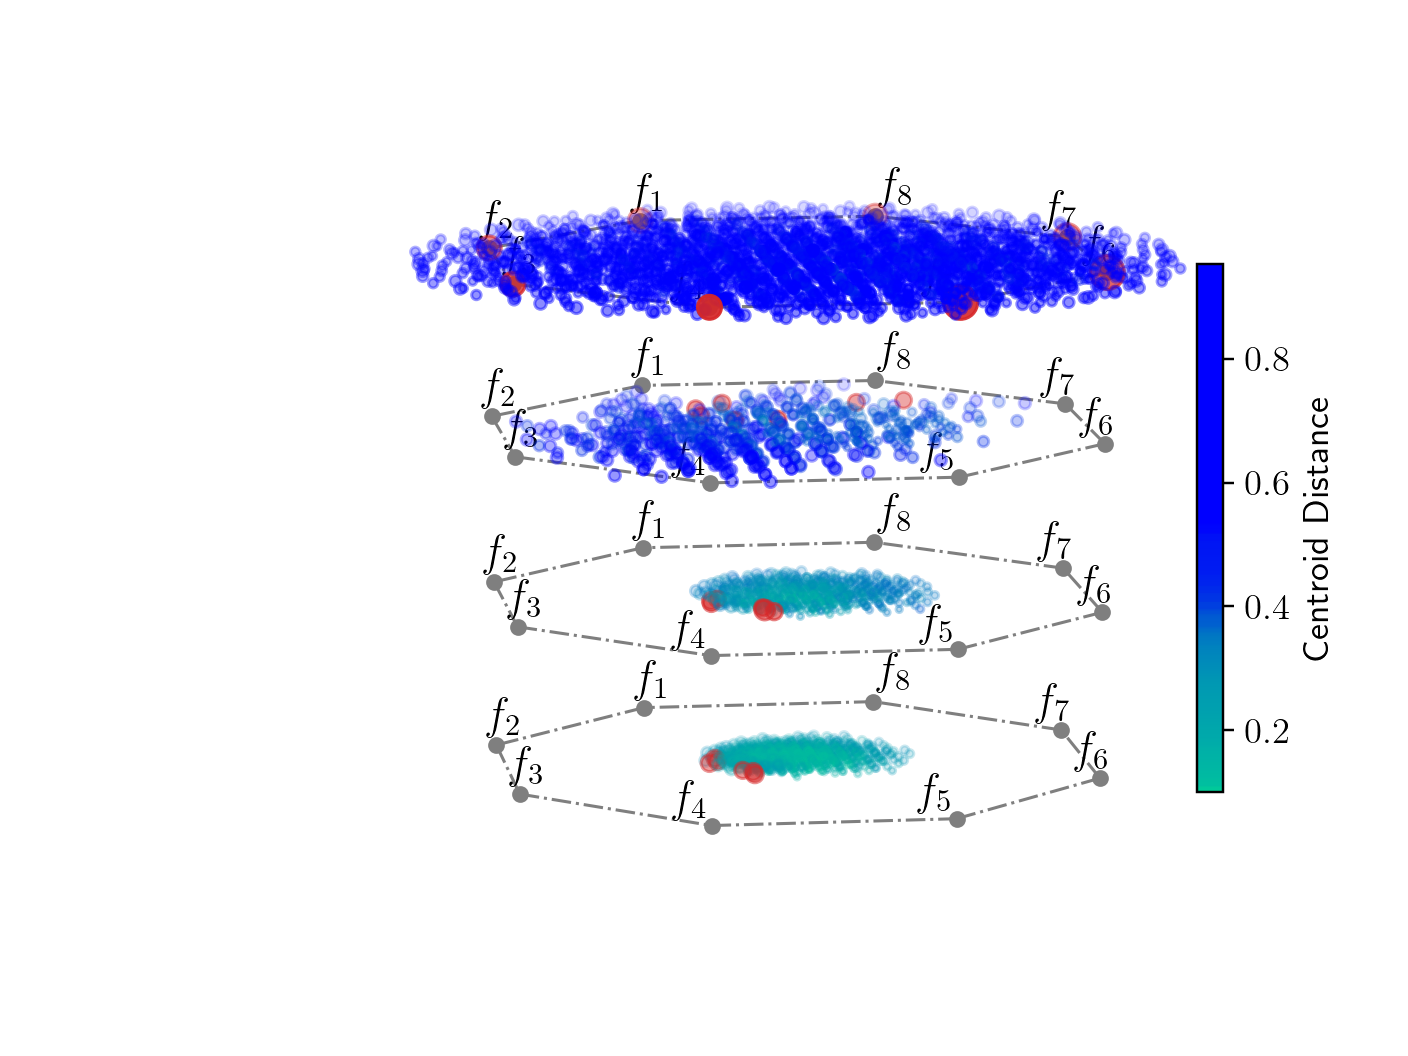

Plotting palette-star-viz.
Loading depth contours from ./data/debmdk-nbi/8d/depth-cont-cvhull.csv.


In [23]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star
from vis.plotting.utils import Arrow3D

for pf in ['debmdk-nbi']:
    for dim in ['8d']:
        fullpathf = "./data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
        if os.path.exists(fullpathf):
            path, filenamef = os.path.split(fullpathf)
            dirs = path.split('/')
            frontname = dirs[-2]

            # load the front
            F = np.loadtxt(fullpathf, delimiter=',')
            print(fullpathf, F.shape, dirs, frontname)
            
            # decide color and sizes
            CV, Mu, Ik = load_props(path)
            S,C,D = decide_size_color(CV, Mu, Ik)
            print(Ik)
            
            # make indices for knee and non-knee points
            I = np.zeros(F.shape[0]).astype(bool)
            I[Ik] = True
            Ip, Ik = ~I, I
            
            # fix point labels
            L = np.array(["" for _ in range(F.shape[0])]).astype(object)
            L[Ip] = "All Other Points"
            L[Ik] = "Knee Points"
            
            # decide what label and gradient to use for the colorbar
            if pf in constrained_pfs:
                cbl = "Normalized Cumulative CV"
                cbg = CV
            else:
                cbl = "Centroid Distance"
                cbg = D
            
            figpath = os.path.join(path, "knee-8d-norm-palette-invsc.pdf")
            depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
            with plt.rc_context({"text.usetex": True, "font.size": 12}):
                # plot
                ax = Axes3D(plt.figure())
                # a more elaborate example
                _,P = paletteviz.plot(F, ax=ax, depth_contours=depth_contour_path, mode='star', \
                                n_partitions=4, s=S, c=C, labels=None, euler=(150,15), \
                                colorbar=(C[Ip], cbg[Ip], cbl, -0.25), verbose=True, \
                                draw_anchors={'labels': [0,1,2,3], \
                                              'polygons': [0,1,2,3], \
                                              'circles': []})

                # try to remove white space as much as possible
                plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
                plt.margins(0,0,0)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.gca().yaxis.set_major_locator(plt.NullLocator())
                plt.gca().zaxis.set_major_locator(plt.NullLocator())

                # save the fig
                plt.savefig(figpath, bbox_inches='tight', dpi=150, pad_inches=0)

                # show
                plt.show()

./data/debmdk-nbi/8d/dataf.csv (5083, 8) ['.', 'data', 'debmdk-nbi', '8d'] debmdk-nbi


<IPython.core.display.Javascript object>


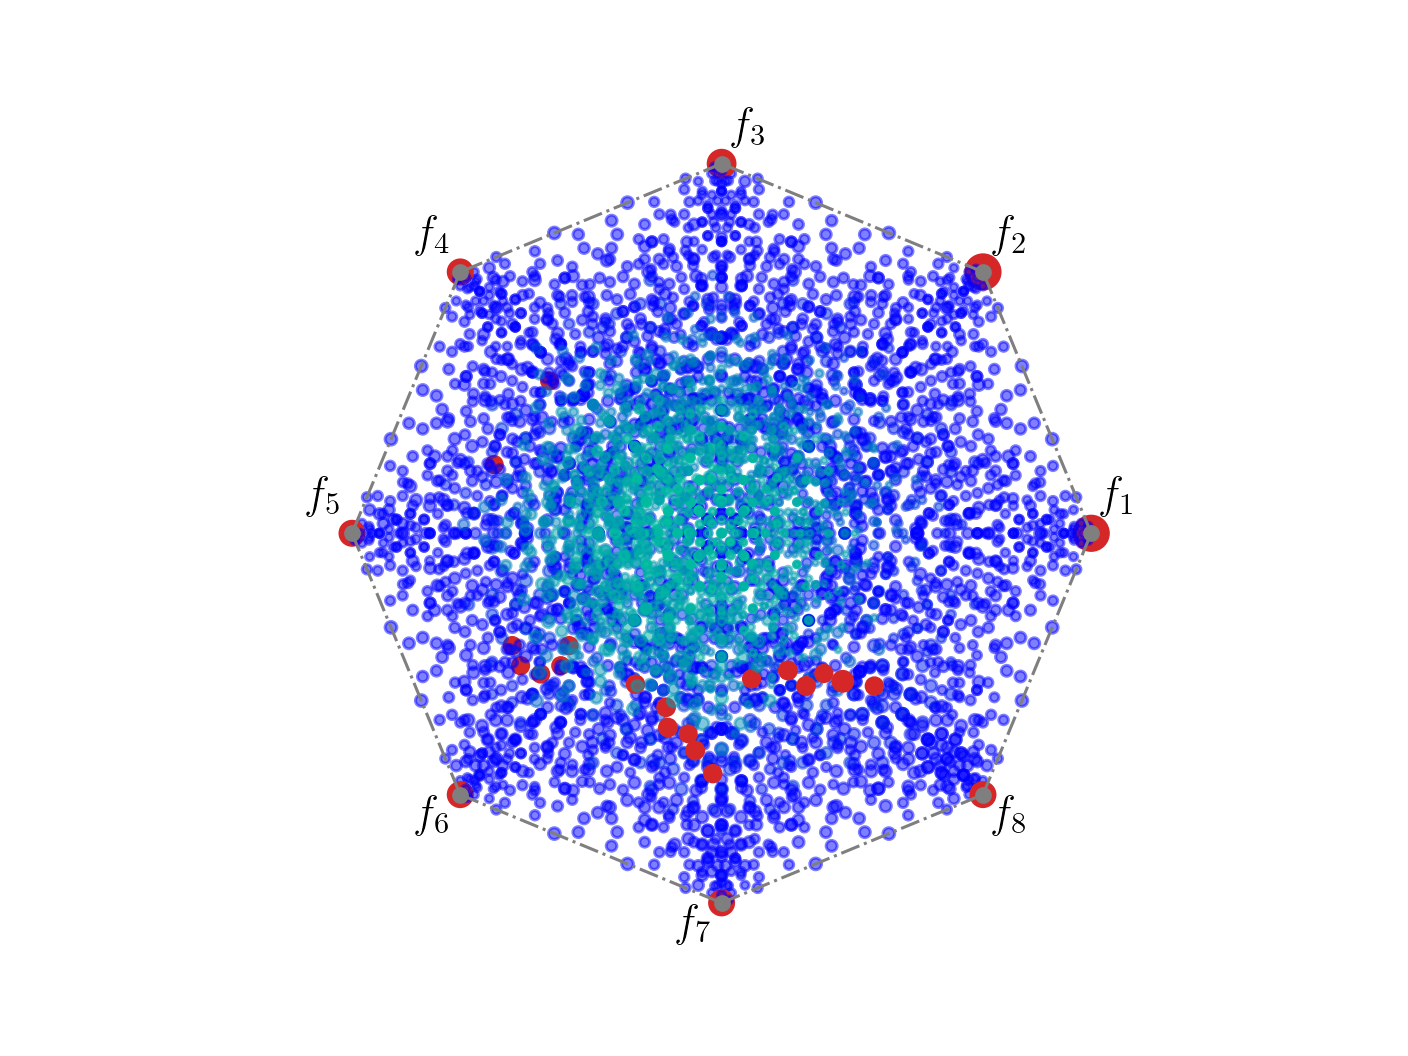

In [25]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import radviz

for pf in ['debmdk-nbi']:
    for dim in ['8d']:
        fullpathf = "./data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
        if os.path.exists(fullpathf):
            path, filenamef = os.path.split(fullpathf)
            dirs = path.split('/')
            frontname = dirs[-2]

            # load the front
            F = np.loadtxt(fullpathf, delimiter=',')
            print(fullpathf, F.shape, dirs, frontname)
            
            # decide color and size
            CV, Mu, Ik = load_props(path)
            S,C,D = decide_size_color(CV, Mu, Ik)
            
            # make indices for knee and non-knee points
            I = np.zeros(F.shape[0]).astype(bool)
            I[Ik] = True
            Ip, Ik = ~I, I
            
            # fix point labels
            L = np.array(["" for _ in range(F.shape[0])]).astype(object)
            L[Ip] = "All Other Points"
            L[Ik] = "Knee Points"
            
            # decide what label and gradient to use for the colorbar
            if pf in constrained_pfs:
                cbl = "Normalized Cumulative CV"
                cbg = CV
            else:
                cbl = "Centroid Distance"
                cbg = D
            
            figpath = os.path.join(path, "knee-8d-radviz.pdf")
            with plt.rc_context({"text.usetex": True, "font.size": 12}):
                radviz.plot(F, ax=plt.figure().gca(), s=S, c=C, labels=None, colorbar=None)
                # save the fig
                plt.savefig(figpath, bbox_inches='tight', dpi=150)
                plt.show()

./data/debmdk-nbi/8d/dataf.csv (5083, 8) ['.', 'data', 'debmdk-nbi', '8d'] debmdk-nbi


<IPython.core.display.Javascript object>


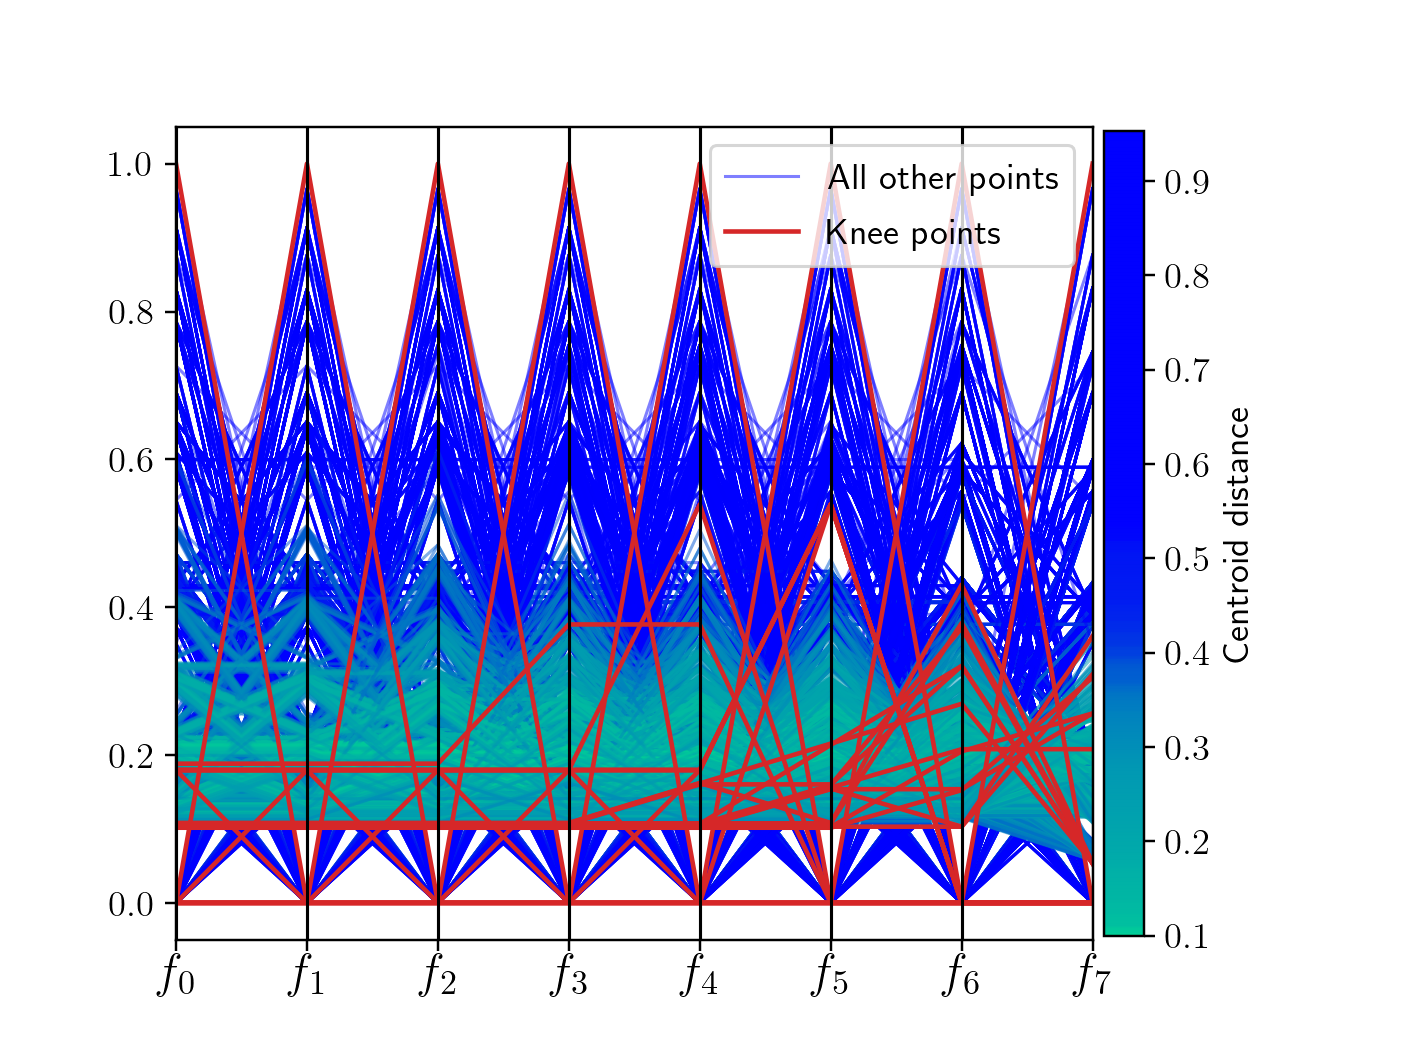

In [21]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import pcp
from vis.utils import transform as tr

for pf in ['debmdk-nbi']:
    for dim in ['8d']:
        fullpathf = "./data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
        if os.path.exists(fullpathf):
            path, filenamef = os.path.split(fullpathf)
            dirs = path.split('/')
            frontname = dirs[-2]

            # load the front
            F = np.loadtxt(fullpathf, delimiter=',')
            # we need to normalize in the case of pcp, otherwise the data will not be
            # visible in some cases.
            F = tr.normalize(F, lb = np.zeros(F.shape[1]), ub = np.ones(F.shape[1]))
            print(fullpathf, F.shape, dirs, frontname)
            
            # decide on colors and sizes
            CV, Mu, Ik = load_props(path)
            S,C,D = decide_size_color(CV, Mu, Ik)
            
            # all indices
            I = np.zeros(F.shape[0]).astype(bool)
            I[Ik] = True
            # Ik = knee indices, Ip = non-knee indices
            Ik,Ip = I, ~I
            
            # xtick_labels
            Lt = np.array(["$f_{{{:d}}}$".format(v) for v in range(F.shape[1])])
            # line labels
            Lp = np.array(["All other points".format(v) for v in range(Ip.shape[0])])
            Lk = np.array(["Knee points".format(v) for v in range(Ik.shape[0])])
                
            if pf in constrained_pfs:
                cbl = "Cumulative normalized CV"
                cbg = CV[Ip]
            else:
                cbl = "Centroid distance"
                cbg = D[Ip]

            figpath = os.path.join(path, "knee-8d-pcp.pdf")
            with plt.rc_context({"text.usetex": True, "font.size": 12}):
                ax = plt.figure().gca()

                # plot non-knee points
                pcp.plot(F[Ip], ax=ax, c=C[Ip], lw=1.00, labels=Lp, xtick_labels=Lt, colorbar=(C[Ip],cbg,cbl))
                # plot knee points
                pcp.plot(F[Ik], ax=ax, c=C[Ik], lw=1.50, labels=Lk)

                # save the fig
                plt.savefig(figpath, bbox_inches='tight', dpi=150, pad_inches=0)
                # show
                plt.show()